# Современные методы анализа данных и машинного обучения, БИ

## НИУ ВШЭ, 2024-25 учебный год

# Семинар 19. Техники глубинного обучения

## Раздел 1. BatchNorm и Dropout

В начале сегодняшнего занятия мы вспомним и повторим на практике две потрясающие техники регуляризации в нейронных сетях, такие как батч-нормализация (BatchNorm) и дропаут (Dropout).

### BatchNorm

Основная идея подхода BatchNorm заключается в том, что для каждого признака он вычитает среднее значение по батчу и делит на выборочное стандартное отклонение по батчу, потом домножает все признаки на обучаемый вес $\gamma$ и прибавляет обучаемый вес $\beta$.

BatchNorm работает по разному во время обучения и предсказний.




Во время обучения:

Пусть на одном нейроне батч-нормализации сам батч, подающийся на вход слою, представляет собой вектор ${x}$ со значениями какого-либо признака и/или выходного нейрона предыдущего слоя, где каждая координата вектора ${x_i}$ — это значение этого признака для $i$-ого объекта батча.

Тогда:

$$\begin{aligned}
\overline{x}_{\mathcal{B}} & \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i} \\
S_{\mathcal{B}}^{2} & \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\overline{x}_{\mathcal{B}}\right)^{2} \\
\widehat{x}_{i} & \leftarrow \frac{x_{i}-\overline{x}_{\mathcal{B}}}{\sqrt{S_{\mathcal{B}}^{2}+\epsilon}} \\
y_{i} & \leftarrow \gamma \widehat{x}_{i}+\beta \equiv \mathrm{B}\mathrm{N}_{\gamma, \beta}\left(x_{i}\right)
\end{aligned}$$


Во время предсказания:

В режиме инференса мы в принципе делаем всё то же самое, но у нас теперь нет батча. Поэтому в качестве $\overline{x}_{\mathcal{B}}$ и $S_{\mathcal{B}}$ мы по идее должны использовать среднее и выборочное стандартное отклонение признака по всему датасету. Нам, конечно, не хочется после обучения снова применять сеть ко всем примерам из обучающего датасета за раз, чтобы вычислить эти статистики, причем еще для каждого признака. Так что вместо заново рассчитанных статистик мы используем экспоненциально затухающее среднее последних батчей.

#### Вопрос

А вообще, зачем нам в целом нужен BatchNorm?

#### Пояснение

Основные аспекты, которые дает BatchNorm:

* Более быстрое обучение
* Возможность обучения более глубоких сетей
* Регуляризация
* Повышение метрик моделей

### BatchNorm для сверток

Для сверточных слоев нам крайне важно, чтобы выполнялся следующий принцип: если в разных частях картинки находятся одинаковые наборы пикселей, то соответствующие выходы сверточного слоя будут одинаковыми.

BatchNorm, который описан выше (в PyTorch его называют BatchNorm1d), этому принципу не удовлетворяет, поскольку, например, для пикселей, находящихся в 1 канале в координате $(1,1)$, среднее и стандартное отклонение могли бы получиться — и скорее всего получатся — не такими же как для пикселя в 1 канале в координате $(10, 10)$. Тогда, даже если изначально в них были одинаковые значения, — после BatchNorm1d они стали бы разными.

В связи с описанным выше, для свёрток мы бы хотели использовать другой BatchNorm (в PyTorch он называется BatchNorm2d), который позволит нам усреднять не только по `batch_size` координате, но и также по `height` и `width` координатам.



Итак, пусть на вход подается тензор (многомерный массив) размера $[B, H, W, C]$. Где $B$ — количество батчей, $H$ — высота картинок, $W$ — ширина картинок, а $C$ — количество каналов.

Тогда BatchNorm1d выполнял бы нормирование так:
```python
mean = mean(t, axis=0)
stddev = stddev(t, axis=0)
for i in 0..B-1:
  out[i,:,:,:] = norm(t[i,:,:,:], mean, stddev)
```

В то время как BatchNorm2d выполняет это так:

```python
mean = mean(t, axis=(0, 1, 2))
stddev = stddev(t, axis=(0, 1, 2))
for i in 0..B-1, x in 0..H-1, y in 0..W-1:
  out[i,x,y,:] = norm(t[i,x,y,:], mean, stddev)
```


### BatchNorm в архитектуре сети

В оригинальной [статье](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43442.pdf) 2015 года, в которой в целом была впервые представлена концепция батч-нормализации, BatchNorm-слой предлагается для сверточных слоев использовать сразу же после свертки, до активации.



Однако свежие исследования показывают, что никакой разницы в целом нет и после активации BatchNorm так же употребим — после нескольких эпох сеть выходит на тот же уровень, как если ставить его перед активацией.

### Dropout

Dropout — это еще один особенный слой, который используется в нейронных сетях. У него, в отличие от BatchNorm, нет обучаемых параметров и есть один гиперпараметр $p$ — вероятность зануления нейрона.

Идея Dropout состоит в том, что во время обучения мы замораживаем случайную часть входа и отдаем оставшееся дальше.

Dropout позволяет тренировать более устойчивые сети и избегать переобучения.

Как же это всё происходит? Как уже было сказано выше, Dropout зануляет случайную часть входов и отдает слой дальше. Допустим, $p=0.5$ (в оригинальной статье рекомендуют начинать с $0.25$). Тогда мы просто убираем половину всего входа!

Такое сильное воздействие сильно повлияет на качество нашей модели, поэтому мы делаем зануление только во время обучения.



Во время обучения:

Для каждого нейрона из входного слоя подбрасываем монетку (генерируем случайное значение из распределения Бернулли)  и зануляем его с вероятностью $p$.

Выход масштабируем заранее, готовясь к инференсу, и поэтому умножаем его на $\frac{1}{1-p}$, чтобы дисперсия выходов осталось такой же, как и на входе.



Во время предсказаний:

Просто выключаем этот слой.

#### Вопрос

На лекции мы обсуждали немного другие формулы для дропаута. Как в таком случае одно бьётся с другим?

#### Вопрос

А вообще, зачем нам в целом нужен Dropout?

#### Пояснение

Основные аспекты, которые дает Dropout:

* Сеть выучивает более устойчивые представления на внутренних слоях.
* Увеличивает число итераций, которые нужны для сходимости.
* По сути, обучает сразу целый ансамбль нейросетей — поскольку даже один убранный нейрон уже создает новую архитектуру — и усредняет по ним выходы.

Любопытно ещё, что при включении Dropout наблюдается необычный эффект: в начале обучения качество на тестовом датасете как правило выше, чем на обучающем. Это связано с тем, что для обучающего датасета у нас есть зануление, которое сильно портит предсказания, а для тестового — нет.

### Взаимодействие Dropout с BatchNorm

На лекции мы говорили с вами о том, что Dropout и BatchNorm могут друг с другом немного конфликтовать. Всё дело в том, что при наличии Dropout выходы этого слоя во время обучения и во время предсказаний будут иметь разное распределение. Поэтому статистики, которые BatchNorm считает для применения во время предсказаний, оказываются неверными.



В связи с этим, если вы хотите использовать BatchNorm и Dropout в одной сети, очень важно, чтобы *все* слои Dropout шли строго после BatchNorm-слоев.

### CNN и перцептрон снова сражаются на CIFAR

Уже знакомая нам рубрика! :)

Только на этот раз обе архитектуры введут в бой тяжелую артиллерию — да, всё верно: BatchNorm и Dropout! :)

In [1]:
# Установим последнюю версию логера wandb
!pip install -q --upgrade wandb

In [2]:
import os
import wandb

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import matplotlib.pyplot as plt
%matplotlib inline

[INFO] Couldn't find torchinfo... installing it.


In [3]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [4]:
class CFG:

# Задаем параметры нашего эксперимента

  api = ""
  project = ""
  entity = ""
  num_epochs = 10
  train_batch_size = 32
  test_batch_size = 512
  num_workers = 2
  lr = 3e-4
  seed = 42
  classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  wandb = False

In [5]:
# Переведем наш класс с параметрами в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Давайте повторим эксперимент между полносвязанной сетью и сверточной на датасете CIFAR10, но теперь добавим туда BatchNorm и Dropout.

In [6]:
class FC_Net(nn.Module):
    def __init__(self,
                 batchnorm=False,
                 dropout=False):
        super(FC_Net, self).__init__()

        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

        if batchnorm:
            self.bn = nn.BatchNorm1d(1024) # включаем BatchNorm
        else:
            self.bn = lambda x: x

        if dropout:
            self.dropout = nn.Dropout(0.2) # включаем Dropout
        else:
            self.dropout = lambda x: x

    def forward(self, x):
        x = x.view(-1, 3072)
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [7]:
model_FC_NET = FC_Net(batchnorm=True, dropout=True)

In [8]:
# Вывод информации о модели с помощью torchinfo
summary(model=model_FC_NET,
        input_size=(32, 3, 32, 32), # входной батч
        col_names=["input_size", "output_size", "num_params", "trainable"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
FC_Net                                   [32, 3, 32, 32]      [32, 10]             --                   True
├─Linear: 1-1                            [32, 3072]           [32, 1024]           3,146,752            True
├─BatchNorm1d: 1-2                       [32, 1024]           [32, 1024]           2,048                True
├─Linear: 1-3                            [32, 1024]           [32, 512]            524,800              True
├─Linear: 1-4                            [32, 512]            [32, 128]            65,664               True
├─Dropout: 1-5                           [32, 128]            [32, 128]            --                   --
├─Linear: 1-6                            [32, 128]            [32, 10]             1,290                True
Total params: 3,740,554
Trainable params: 3,740,554
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 119.70
Input s

In [9]:
class CIFAR_Net(torch.nn.Module):
    def __init__(self):
        super(CIFAR_Net, self).__init__()

        self.batch_norm0 = torch.nn.BatchNorm2d(3) # в качестве параметра указываем только размерность выхода предыдущего слоя

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(2, 2)

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.act3  = torch.nn.ReLU()


        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.act4  = torch.nn.Tanh()

        self.dropout1 = nn.Dropout(0.3)

        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()

        self.dropout2 = nn.Dropout(0.25)

        self.fc3   = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [10]:
model_CNN = CIFAR_Net()

In [11]:
# Вывод информации о модели с помощью torchinfo
summary(model=model_CNN,
        input_size=(32, 3, 32, 32), # входной батч
        col_names=["input_size", "output_size", "num_params", "trainable"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
CIFAR_Net                                [32, 3, 32, 32]      [32, 10]             --                   True
├─BatchNorm2d: 1-1                       [32, 3, 32, 32]      [32, 3, 32, 32]      6                    True
├─Conv2d: 1-2                            [32, 3, 32, 32]      [32, 16, 32, 32]     448                  True
├─BatchNorm2d: 1-3                       [32, 16, 32, 32]     [32, 16, 32, 32]     32                   True
├─ReLU: 1-4                              [32, 16, 32, 32]     [32, 16, 32, 32]     --                   --
├─MaxPool2d: 1-5                         [32, 16, 32, 32]     [32, 16, 16, 16]     --                   --
├─Conv2d: 1-6                            [32, 16, 16, 16]     [32, 32, 16, 16]     4,640                True
├─BatchNorm2d: 1-7                       [32, 32, 16, 16]     [32, 32, 16, 16]     64                   True
├─ReLU: 1-8       

In [12]:
# функция обучения
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # переводим в режим обучения!
    train_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # обнуляем градиенты
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss = criterion(output, target) # считаем лосс
        train_loss.backward() # обратный проход
        optimizer.step() # делаем шаг оптимизатором

    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    # логируем функцию потерь и точность
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [13]:
# функция инференса
def test(model, device, test_loader, criterion, WANDB):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [14]:
def main_CIFAR(model):

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available()

    seed_everything(CFG.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': CFG.num_workers, 'pin_memory': True} if use_cuda else {}

    # загружаем датасет CIFAR10
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) # нормализуем значения
                       ])),
        batch_size=CFG.train_batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                       ])),
        batch_size=CFG.test_batch_size, shuffle=False, **kwargs)

    model = model.to(device)


    if CFG.wandb:
        wandb.watch(model, log='all')

    optimizer = optim.Adam(model.parameters(),
                          lr=CFG.lr)

    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, CFG.num_epochs + 1):
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is ended!')

Итак, поехали!

In [15]:
main_CIFAR(model_FC_NET)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]



Epoch: 1


100%|██████████| 1563/1563 [00:20<00:00, 77.10it/s]


Train set: Average loss: 1.2914, Accuracy: 41.37%


Test set: Average loss: 1.5294, Accuracy: 48.61%

Epoch: 2


100%|██████████| 1563/1563 [00:17<00:00, 90.61it/s]


Train set: Average loss: 1.2668, Accuracy: 49.27%


Test set: Average loss: 1.4672, Accuracy: 50.82%

Epoch: 3


100%|██████████| 1563/1563 [00:23<00:00, 67.12it/s]


Train set: Average loss: 1.1596, Accuracy: 53.09%


Test set: Average loss: 1.4456, Accuracy: 53.10%

Epoch: 4


100%|██████████| 1563/1563 [00:17<00:00, 86.97it/s]


Train set: Average loss: 1.1098, Accuracy: 56.43%


Test set: Average loss: 1.4598, Accuracy: 53.65%

Epoch: 5


100%|██████████| 1563/1563 [00:15<00:00, 99.36it/s] 


Train set: Average loss: 1.9663, Accuracy: 59.18%


Test set: Average loss: 1.4022, Accuracy: 54.17%

Epoch: 6


100%|██████████| 1563/1563 [00:16<00:00, 94.65it/s]


Train set: Average loss: 1.1335, Accuracy: 61.80%


Test set: Average loss: 1.4751, Accuracy: 55.17%

Epoch: 7


100%|██████████| 1563/1563 [00:15<00:00, 97.82it/s]


Train set: Average loss: 1.0135, Accuracy: 64.62%


Test set: Average loss: 1.3893, Accuracy: 55.01%

Epoch: 8


100%|██████████| 1563/1563 [00:20<00:00, 77.85it/s] 


Train set: Average loss: 0.9819, Accuracy: 67.43%


Test set: Average loss: 1.4602, Accuracy: 56.61%

Epoch: 9


100%|██████████| 1563/1563 [00:15<00:00, 100.93it/s]


Train set: Average loss: 1.4913, Accuracy: 70.06%


Test set: Average loss: 1.3979, Accuracy: 56.49%

Epoch: 10


100%|██████████| 1563/1563 [00:17<00:00, 87.74it/s] 


Train set: Average loss: 0.9085, Accuracy: 72.25%


Test set: Average loss: 1.4124, Accuracy: 55.60%
Training is ended!


Ну, шикарно, шикарно!

В сравнении с прошлым разом, конечно :)

In [16]:
main_CIFAR(model_CNN)


Epoch: 1


100%|██████████| 1563/1563 [00:20<00:00, 78.06it/s]


Train set: Average loss: 1.1783, Accuracy: 54.37%


Test set: Average loss: 1.0671, Accuracy: 64.76%

Epoch: 2


100%|██████████| 1563/1563 [00:17<00:00, 87.82it/s]


Train set: Average loss: 1.5193, Accuracy: 65.72%


Test set: Average loss: 1.0419, Accuracy: 67.96%

Epoch: 3


100%|██████████| 1563/1563 [00:19<00:00, 79.41it/s]



Train set: Average loss: 0.8549, Accuracy: 69.96%
Test set: Average loss: 0.9174, Accuracy: 70.56%

Epoch: 4


100%|██████████| 1563/1563 [00:20<00:00, 75.52it/s]


Train set: Average loss: 0.7816, Accuracy: 73.11%


Test set: Average loss: 0.9061, Accuracy: 72.05%

Epoch: 5


100%|██████████| 1563/1563 [00:18<00:00, 82.74it/s]


Train set: Average loss: 1.0888, Accuracy: 75.69%


Test set: Average loss: 0.8759, Accuracy: 72.25%

Epoch: 6


100%|██████████| 1563/1563 [00:18<00:00, 86.74it/s]


Train set: Average loss: 0.6134, Accuracy: 77.44%


Test set: Average loss: 0.9202, Accuracy: 71.91%

Epoch: 7


100%|██████████| 1563/1563 [00:18<00:00, 86.23it/s]


Train set: Average loss: 1.0107, Accuracy: 79.21%


Test set: Average loss: 0.8002, Accuracy: 73.11%

Epoch: 8


100%|██████████| 1563/1563 [00:19<00:00, 80.68it/s]


Train set: Average loss: 0.6945, Accuracy: 80.81%


Test set: Average loss: 0.8269, Accuracy: 73.29%

Epoch: 9


100%|██████████| 1563/1563 [00:18<00:00, 86.75it/s]


Train set: Average loss: 0.6794, Accuracy: 82.08%


Test set: Average loss: 0.7770, Accuracy: 73.95%

Epoch: 10


100%|██████████| 1563/1563 [00:18<00:00, 85.30it/s]


Train set: Average loss: 0.3536, Accuracy: 83.36%


Test set: Average loss: 0.8052, Accuracy: 74.06%
Training is ended!


Видим, что математика нас не обманула, обучение действительно ускорилось, а качество существенно выросло!

## Раздел 2. Transfer learning

Допустим, у нас есть свой набор данных, и мы хотим обучить сеть классифицировать объекты из нашей выборки.  
Есть 3 возможных подхода к задаче:

* **1. Написать свою собственную нейронную сеть**
    * Если Вы работаете в OpenAI, например, то очень хороший подход

* **2. CNN как средство для извлечения признаков (Feature Extractor)**
    * Берём сетку, обученную на ImageNet
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию. Веса предыдущих слоёв **заморожены**, мы их не трогаем.
    * Запускаем сеть на новом датасете
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **3. CNN, которую можно дообучить (Fine-Tuning)**  
    * Берём сетку, обученную на ImageNet  
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.  
    * Теперь распространяем backpropagation ещё на сколько-то слоёв назад (размораживаем веса в этих слоях), чтобы скорректировать их под новые данные.
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете  

In [17]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Возьмем датасет Пчелы и Муравьи. Задача — по входной картинке определить насекомое (либо пчела, либо муравей).  

In [18]:
# скачиваем датасет и распаковываем
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P /content/data/
!mkdir /content/data/hymenoptera_data/
!unzip -q /content/data/hymenoptera_data.zip -d /content/data/hymenoptera_data/

--2025-05-27 11:34:59--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.173.121.90, 18.173.121.83, 18.173.121.119, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.173.121.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/content/data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   160MB/s    in 0.3s    

2025-05-27 11:34:59 (160 MB/s) - ‘/content/data/hymenoptera_data.zip’ saved [47286322/47286322]



In [19]:
# определим несколько констант

INPUT_DIR = '/content/data/hymenoptera_data/hymenoptera_data'
# поканальные значения среднего и стандартного отклонения для ImageNet
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 8

In [20]:
# выполним трансформации
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), # меняем размер
        transforms.RandomCrop(244), # вырезаем случайную область указанного размера
        transforms.RandomHorizontalFlip(), # зеркальное отражение по горизонтали
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) # нормализация
    ]),
    'val': transforms.Compose([ # на валидации нельзя делать никаких преобразований (кроме изменения размера),
                               # ведь мы должны проверить модель на реальных картинках
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}

In [21]:
dataset = {ds: torchvision.datasets.ImageFolder(
    root=os.path.join(INPUT_DIR, ds),
    transform=data_transforms[ds]
) for ds in ['train', 'val']}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'val']}
dataset_classes = dataset['train'].classes
print('classes:', dataset_classes, '\nsize', dataset_size)

# загружаем данные
dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=CFG.num_workers
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=CFG.num_workers
    ),
}

classes: ['ants', 'bees'] 
size {'train': 244, 'val': 153}


In [22]:
# функция разбиения по батчам
def get_batches(dataloader, num_of_batches=3):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

In [23]:
# функция отрисовки батчей
def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * IMAGENET_STD + IMAGENET_MEAN
    images = np.clip(images, 0, 1)
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

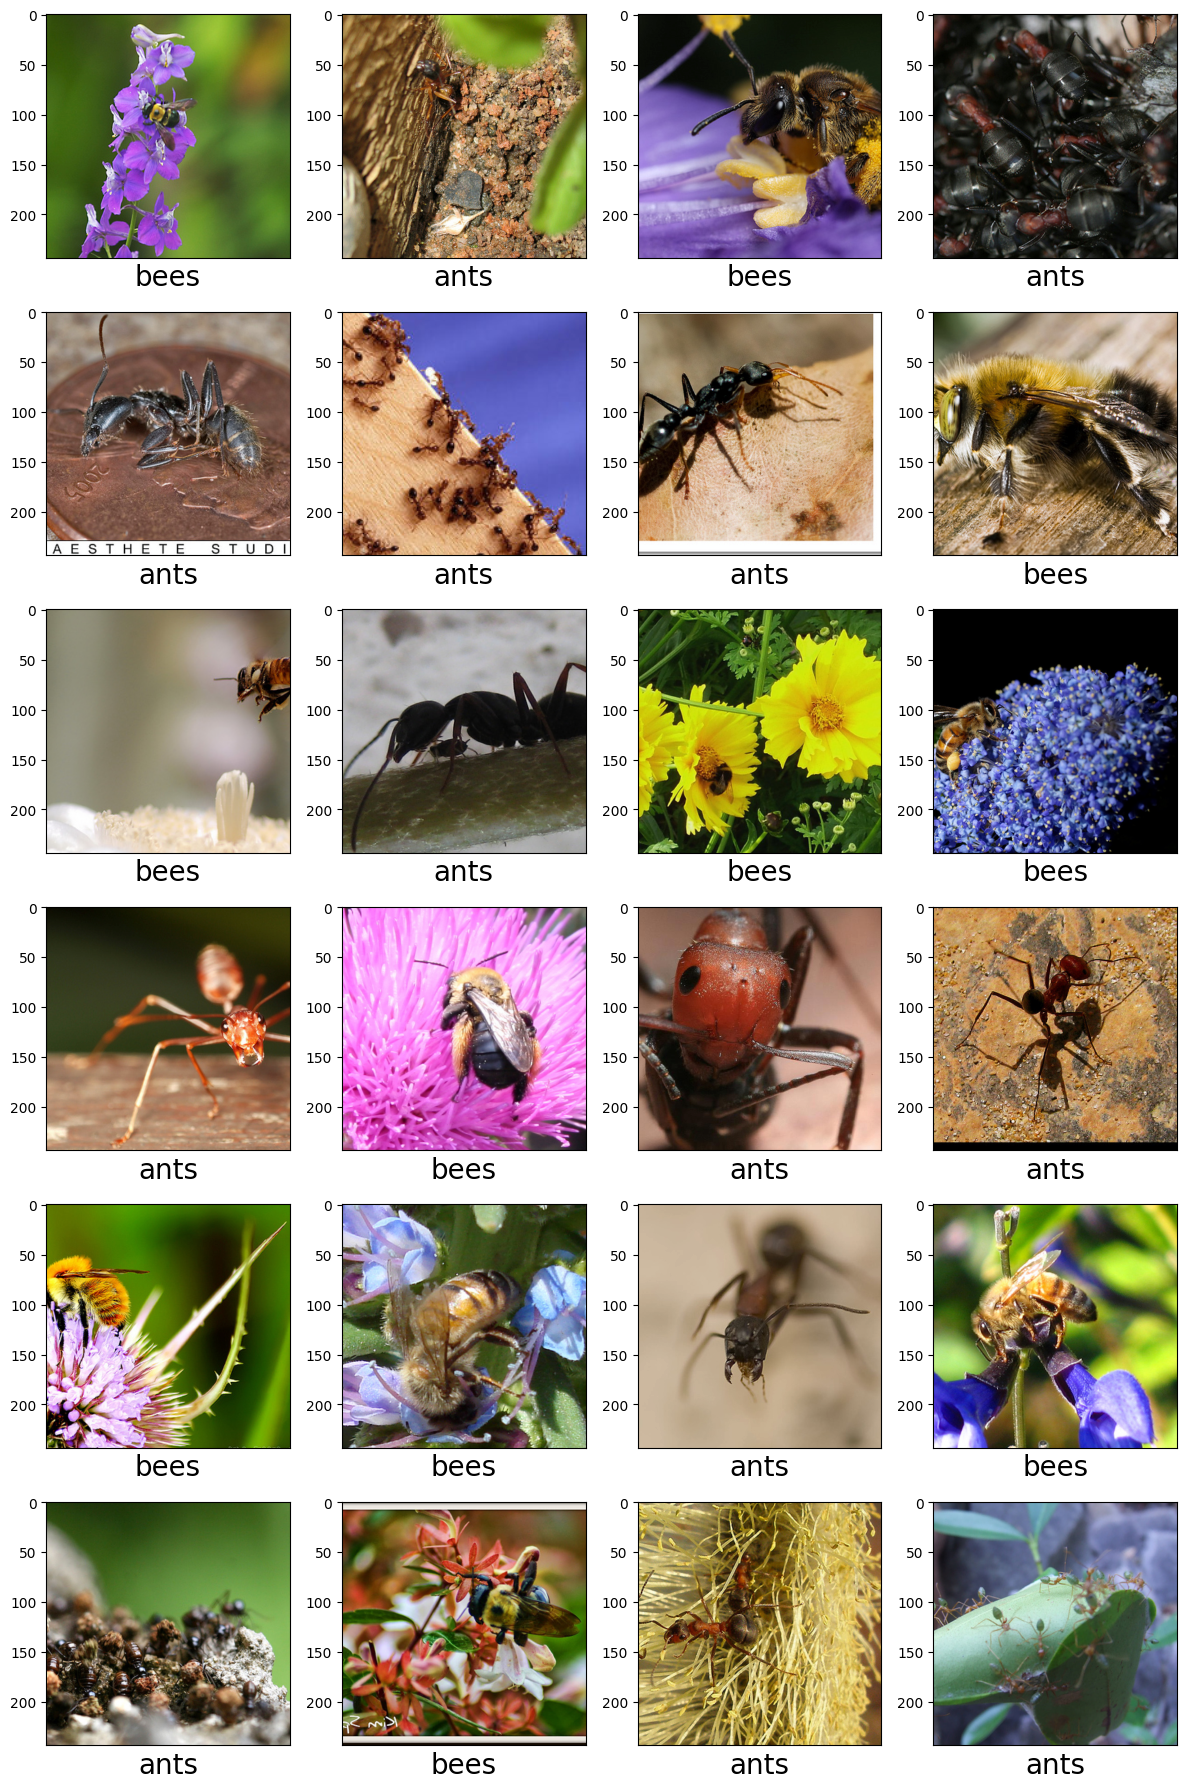

In [24]:
# выведем 12 картинок
images, classes = get_batches(dataloader['train'])
show_batches(images, classes)

Красота, да? Главное — не пересматривать семинар перед сном! :)

In [25]:
# функция отрисовки метрик
def show_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['val'], label='val')
    plt.grid()
    plt.legend()
    plt.show()

In [26]:
# функция обучения моделей
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    sheduler: torch.nn.Module,
    epochs: int = 5
) -> tuple[torch.nn.Module, dict]:

    r"""Обучение модели. Возвращает лучшую модель, словарь потерь при обучении и валидации, словарь точностей при обучении и валидации.
    Args:
        model (torch.nn.Module): модель
        criterion (torch.nn.Module): функция потерь
        optimizer (torch.nn.Module): алгоритм оптимизации
        sheduler (torch.nn.Module): расписание изменения скорости обучения
        epochs (int): количество эпох
    """

    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_model_weights = model.state_dict()
    best_accuracy = 0.
    progress = tqdm(range(epochs), desc='Epoch:')

    for epoch in progress:
        for phase in ['train', 'val']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))

            for inputs, labels in tqdm(dataloader[phase], desc=f'Phase {phase}:'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)

                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                sheduler.step()

            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

Как видите, здесь мы для разнообразия написали немного другую функцию для обучения нейронной сети.

Итак, начнем наш transfer learning.

### AlexNet

AlexNet — это нейронная сеть, которая победила в ILSVRC (соревнование по классификации картинок из ImageNet) в 2012 году и стала основой для многих других архитектур. Впервые она была представлена в статье  “ImageNet Classification with Deep Convolutional Neural Networks”.

Архитектура этой сети представлена на картинке ниже:

<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png">

По сути, AlexNet — это следующая значимая архитектура после LeNet, которую мы уже рассматривали на предыдущем занятии.

In [27]:
from torchvision.models import alexnet
from torchvision.models import AlexNet_Weights

In [28]:
AlexNet = alexnet(weights=AlexNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 177MB/s]


In [29]:
# Вывод информации о модели с помощью torchinfo
summary(model=AlexNet,
        input_size=(8, 3, 256, 256), # входной батч
        col_names=["input_size", "output_size", "num_params", "trainable"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
AlexNet                                  [8, 3, 256, 256]     [8, 1000]            --                   True
├─Sequential: 1-1                        [8, 3, 256, 256]     [8, 256, 7, 7]       --                   True
│    └─Conv2d: 2-1                       [8, 3, 256, 256]     [8, 64, 63, 63]      23,296               True
│    └─ReLU: 2-2                         [8, 64, 63, 63]      [8, 64, 63, 63]      --                   --
│    └─MaxPool2d: 2-3                    [8, 64, 63, 63]      [8, 64, 31, 31]      --                   --
│    └─Conv2d: 2-4                       [8, 64, 31, 31]      [8, 192, 31, 31]     307,392              True
│    └─ReLU: 2-5                         [8, 192, 31, 31]     [8, 192, 31, 31]     --                   --
│    └─MaxPool2d: 2-6                    [8, 192, 31, 31]     [8, 192, 15, 15]     --                   --
│    └─Conv2d: 2-7    

Уже внушительная модель!

In [30]:
num_in_features = 9216 # входная размерность слоя классификатора
num_out_features = 2 # количество классов

# создаем слой классификатор
AlexNet.classifier = torch.nn.Linear(num_in_features, num_out_features)
AlexNet.to(DEVICE)

# функция потерь кросс-энтропия и оптимизатор - Адам
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNet.parameters(), lr=1e-4)

# умножаем learning_rate на 0.1 каждые 7 эпох для более качественного обучения
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(AlexNet, loss, optimizer, sheduler)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

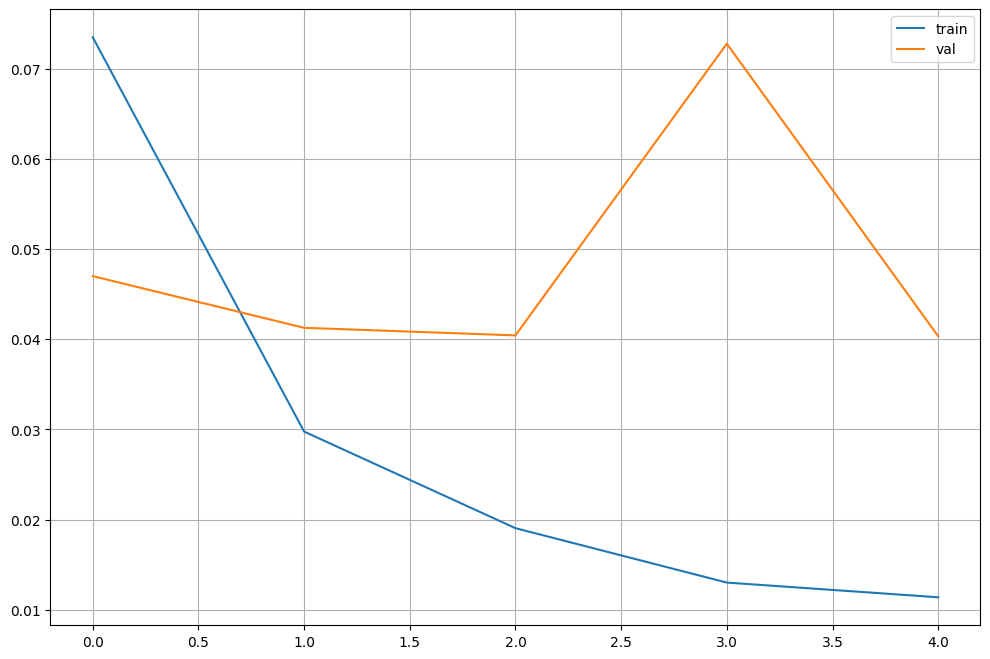

In [31]:
show_metrics(losses)

In [32]:
# замораживаем 6 слоев
layers_to_freeze = 6
for i, (name, param) in enumerate(AlexNet.features.named_parameters()):
    if i < layers_to_freeze:
        param.requires_grad = False
    print(f'{name:30}{param.requires_grad}')

# создаем слой классификатор
AlexNet.classifier = torch.nn.Linear(num_in_features, num_out_features)
AlexNet.to(DEVICE)

# функция потерь кросс-энтропия
loss = torch.nn.CrossEntropyLoss()
retrain_layers = list(AlexNet.features.parameters())[layers_to_freeze:] + list(AlexNet.classifier.parameters())

# обучаем только не замороженные слои
optimizer = torch.optim.Adam(retrain_layers, lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(AlexNet, loss, optimizer, sheduler)

0.weight                      False
0.bias                        False
3.weight                      False
3.bias                        False
6.weight                      False
6.bias                        False
8.weight                      True
8.bias                        True
10.weight                     True
10.bias                       True


Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

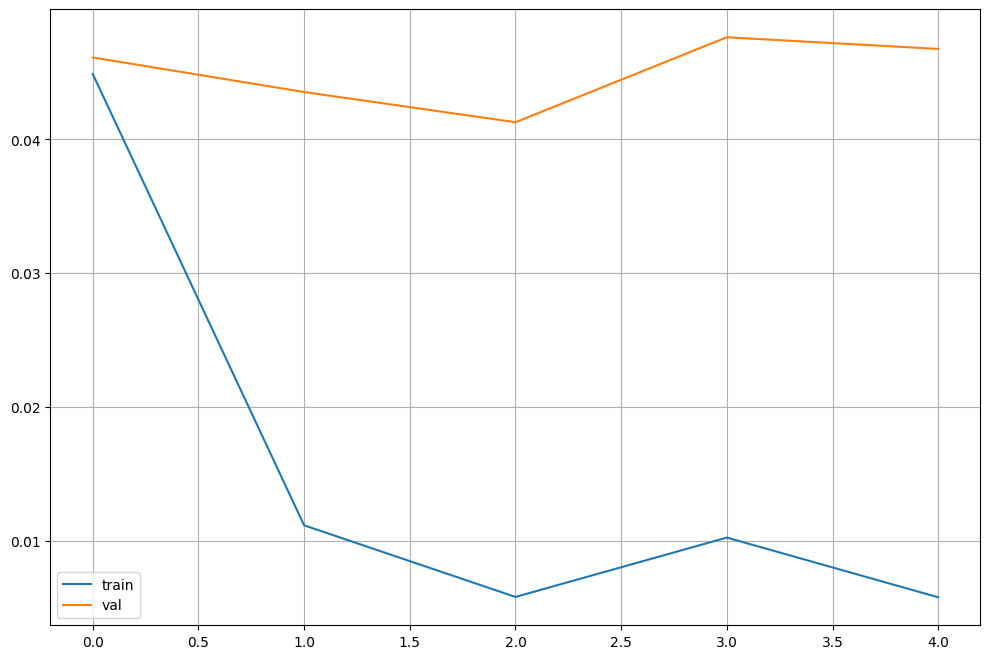

tensor(0.8954, device='cuda:0')

In [33]:
show_metrics(losses)
max(accuracies['val'])

In [34]:
AlexNet.classifier = torch.nn.Linear(num_in_features, num_out_features)
AlexNet.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer_params = [  # включаем индивидуальный learning rate для каждого слоя
    {'params': AlexNet.features.parameters(), 'lr': 1e-5},
    {'params': AlexNet.classifier.parameters()},
]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(AlexNet, loss, optimizer, sheduler)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

Phase train::   0%|          | 0/31 [00:00<?, ?it/s]

Phase val::   0%|          | 0/20 [00:00<?, ?it/s]

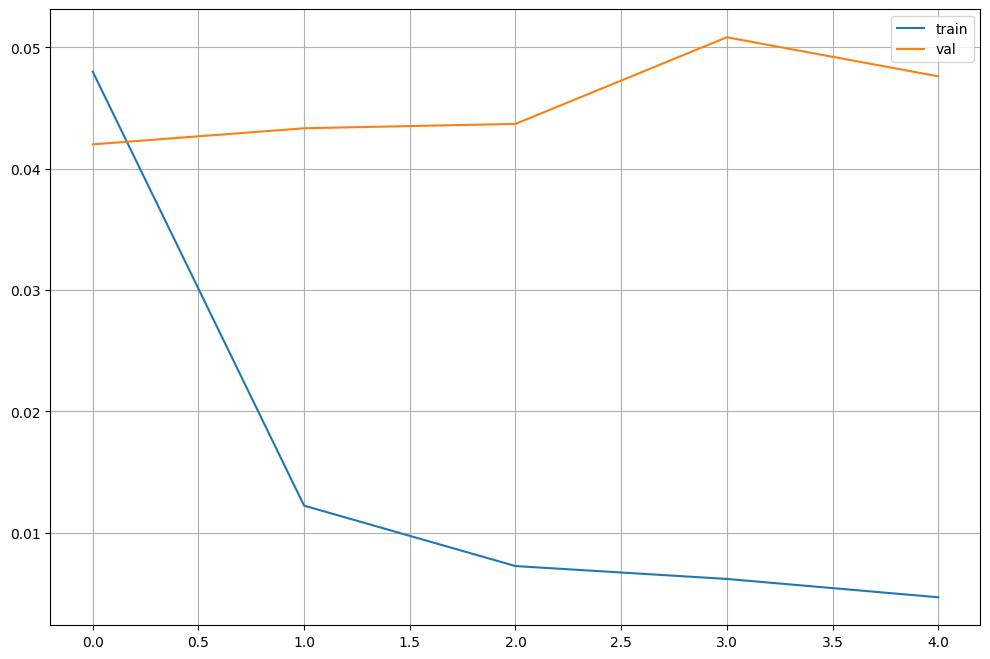

tensor(0.9020, device='cuda:0')

In [35]:
show_metrics(losses)
max(accuracies['val'])

Видим, что наши ухищрения не прошли даром, качество выросло и мы теперь лучше определяем разницу между Bees & Ants :)